In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import helper # my function that i added
import missingno as msno

# Makes figures a higher resolution. Better for saving.
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

Iowa State University colors.

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))
sns.color_palette()

[(1.0, 0.043137254901960784, 0.01568627450980392),
 (0.9450980392156862, 0.7450980392156863, 0.2823529411764706),
 (0.7254901960784313, 0.592156862745098, 0.3568627450980392),
 (0.5450980392156862, 0.3568627450980392, 0.1607843137254902),
 (0.3215686274509804, 0.2784313725490196, 0.15294117647058825)]

Import and split data

In [3]:
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0)

train, test = helper.stratified_split(housing,'Neighborhood')

In [4]:
df_dict = {'housing': housing, 'train': train, 'test': test}
for name, df in df_dict.items():
    print('Shape of '+name+' '+str(df.shape))

Shape of housing (2579, 81)
Shape of train (1934, 81)
Shape of test (645, 81)


In [5]:
# looking at variables I was asked to focus on.
categorical_features = ['Fireplaces','FireplaceQu','MiscFeature',
                        'MSSubClass','MSZoning','BldgType','HouseStyle',
                        'FullBath','HalfBath']
numerical_features = ['MiscVal','YearBuilt','YearRemodAdd','PID','GrLivArea',
                     '1stFlrSF','2ndFlrSF','LowQualFinSF']
target_feature = ['SalePrice']
hayden_features = categorical_features + numerical_features + target_feature

I'm looking at missing values for all the entire housing df and not just the train df. I don't think there is any risk of dataleakage.

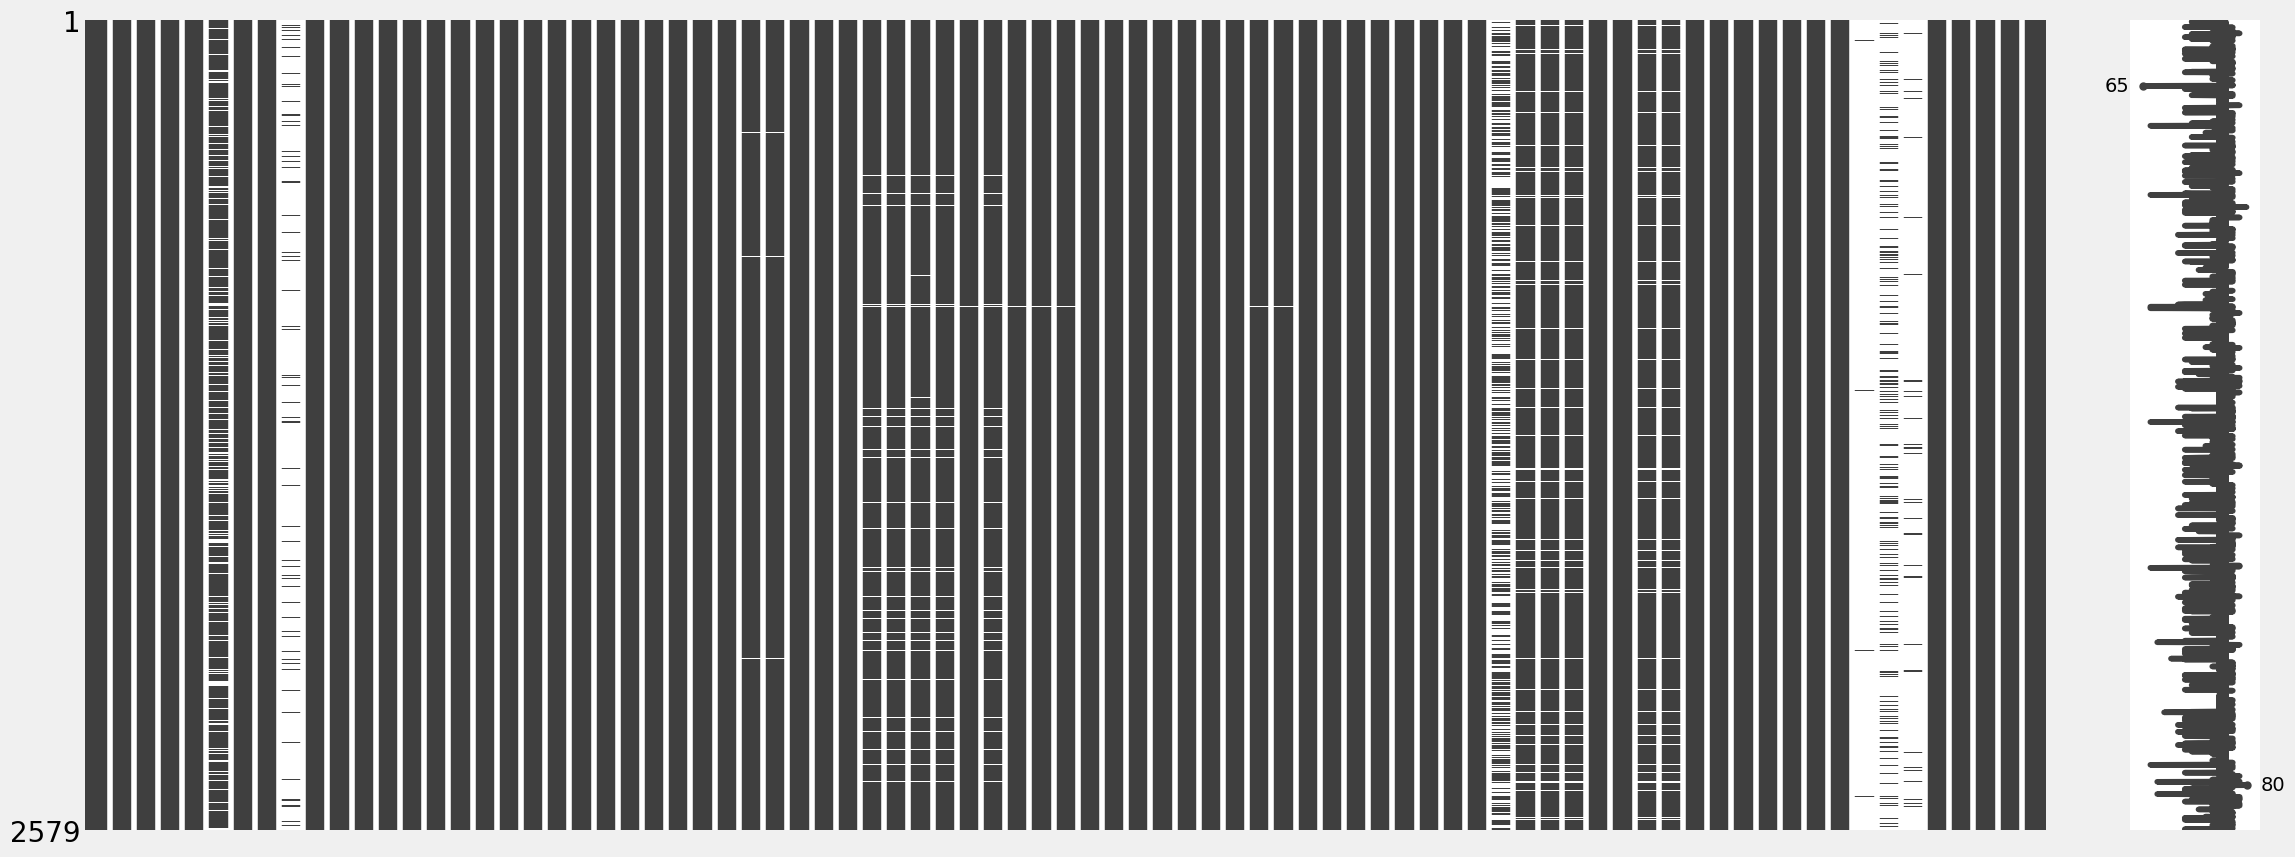

In [6]:
msno.matrix(housing)
plt.show()

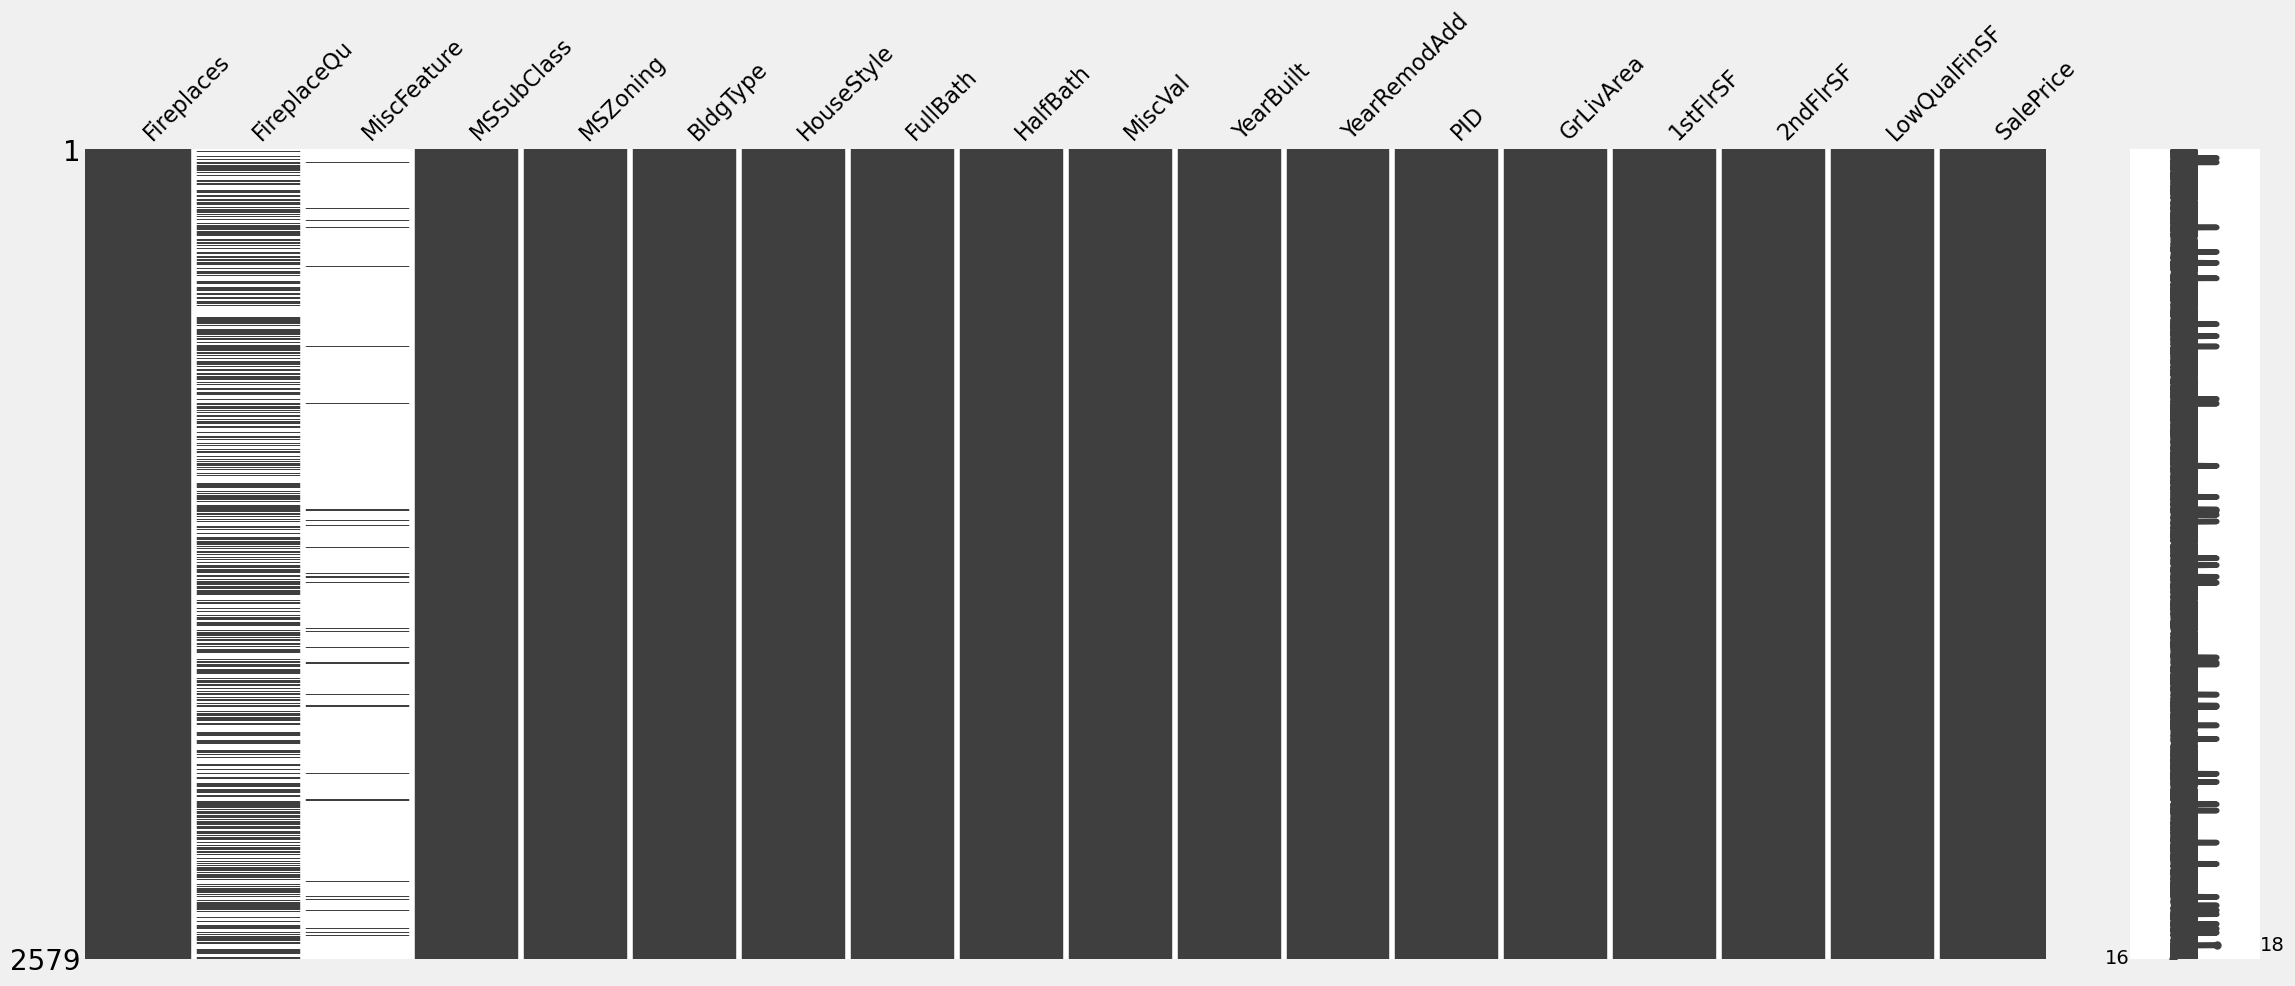

In [7]:
msno.matrix(housing[hayden_features])
plt.show()

In [8]:
housing.Fireplaces.unique()

array([1, 0, 2, 3, 4])

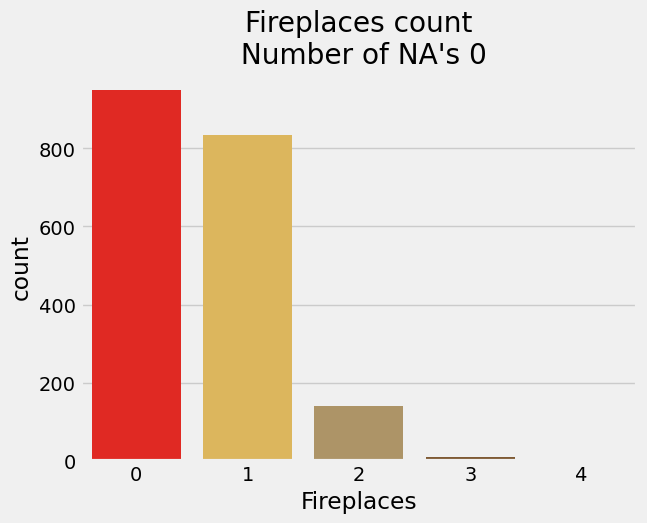

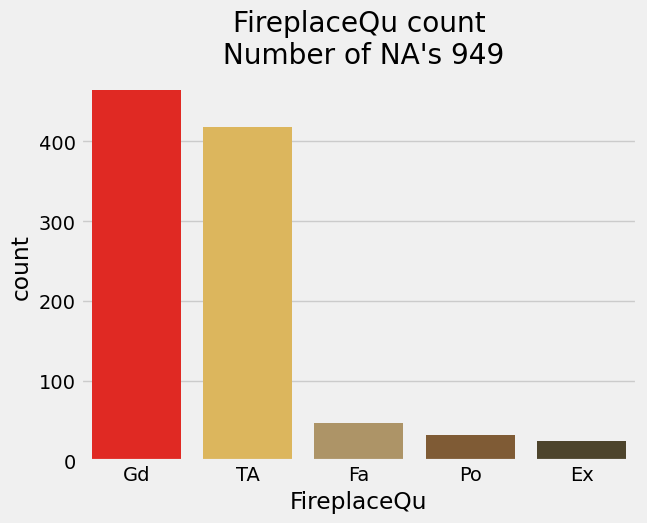

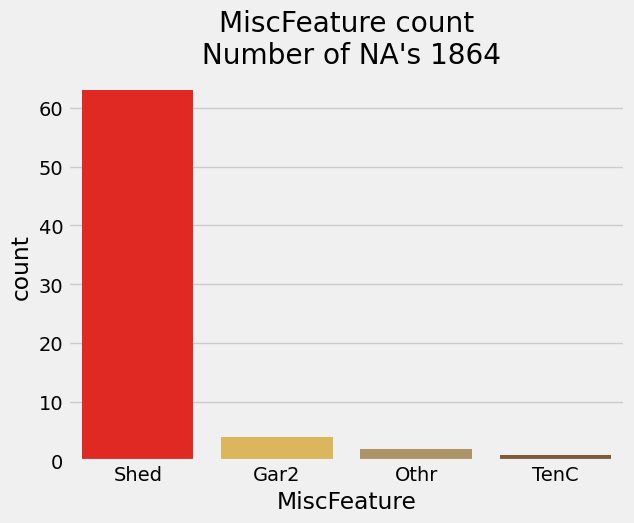

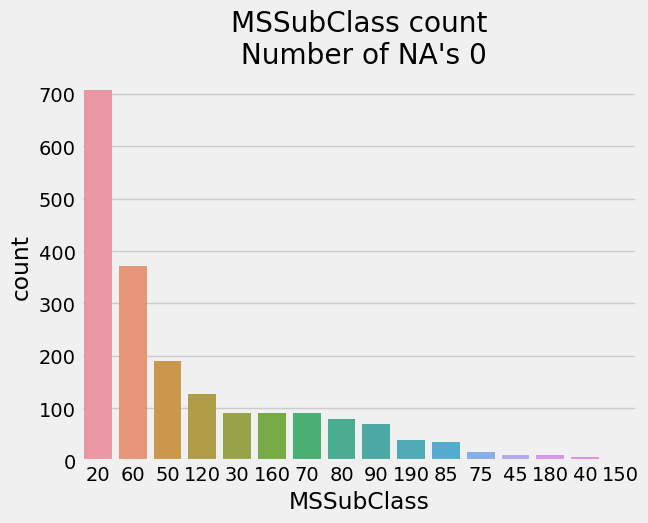

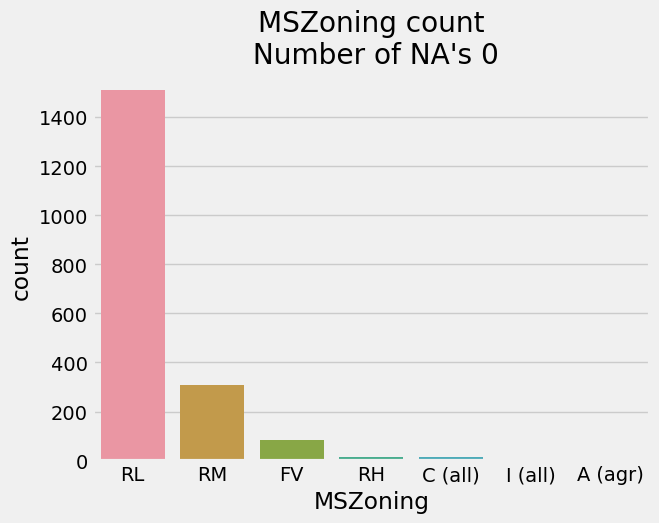

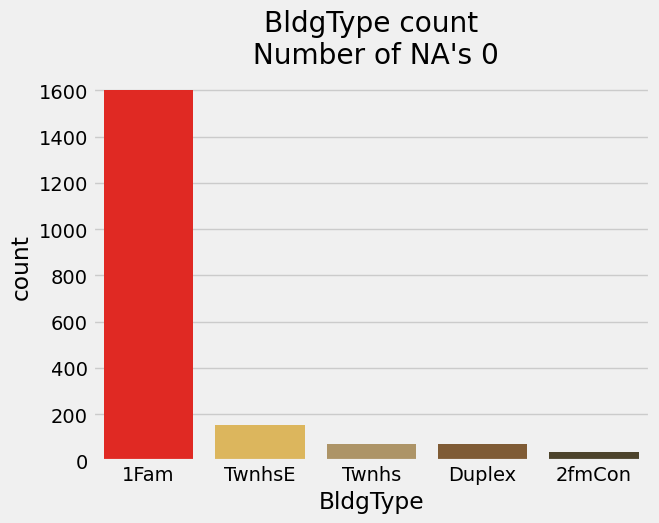

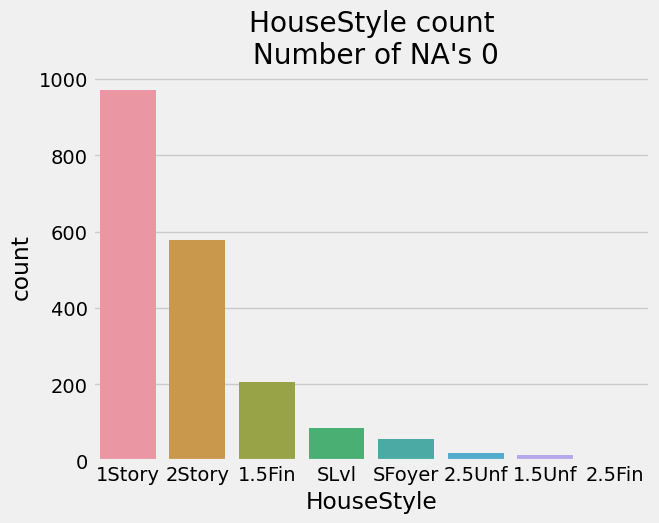

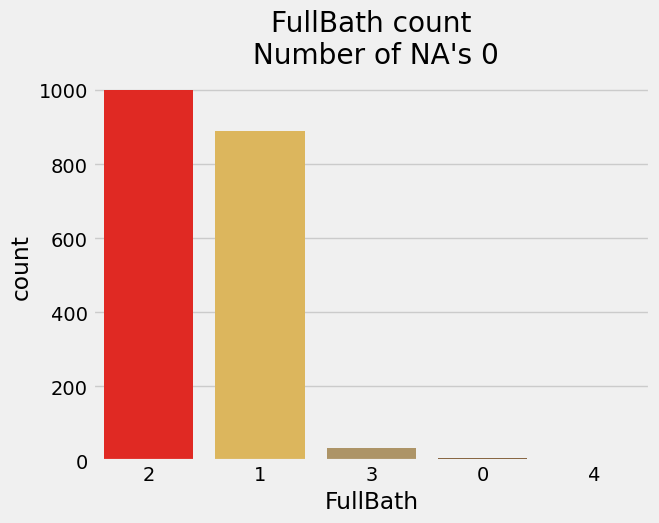

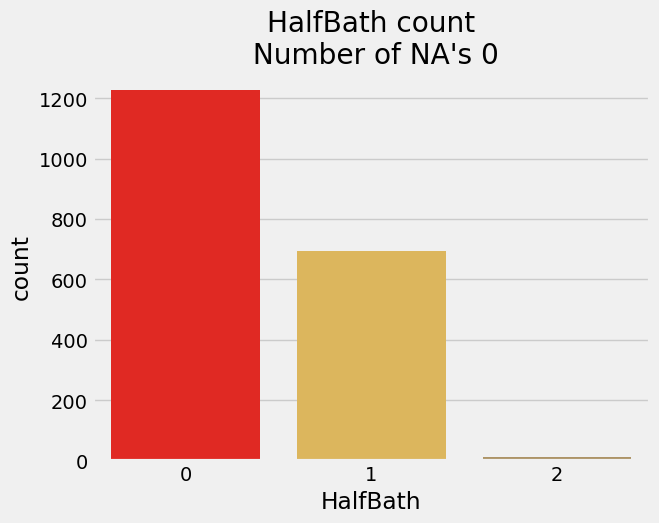

In [9]:
for cat_feat in categorical_features:
    g = sns.countplot(x=cat_feat, data=train,
                      order = housing[cat_feat].value_counts().index)
    plt.title(f"{cat_feat} count\n Number of NA's {train[cat_feat].isnull().sum(axis = 0)}")

    plt.show()

### Quality Features

In [10]:
quality_dict = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
qulity_features = ['FireplaceQu']
for qulity_feature in qulity_features:
    train[qulity_feature] = train[qulity_feature].map(quality_dict).fillna(value=0)



### NA's are meant to be 'None' Features

In [11]:
na_none_features = ['MiscFeature']
for na_none_feature in na_none_features:
    train[na_none_feature] = train[na_none_feature].fillna(value = 'None')
train['MiscFeature']

0       None
1       None
2       None
3       None
4       None
        ... 
1929    None
1930    None
1931    None
1932    None
1933    None
Name: MiscFeature, Length: 1934, dtype: object

### Numeric categories that should be Categorical

Thoughts: could consider feature engineering and taking out information like 1, 1-1/2, or 2 story builidings. But I think that will be covered in other features like 2nd floor square footage. Or age but that is in the year built.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [12]:
# comment ot make more clear.
num_cat_features = ['MSSubClass']
num_cat_prefix_dict = {'MSSubClass': 'sub_class_'}
for num_cat_feature in num_cat_features:
    num_feats = list(train[num_cat_feature].unique())
    prefix = num_cat_prefix_dict[num_cat_feature]
    cat_feats = [prefix+str(num_feat) for num_feat in num_feats]
    num_to_cat_dict = dict(zip(num_feats,cat_feats))
    train[num_cat_feature] = train[num_cat_feature].map(num_to_cat_dict)

### No additional cleaning

MSZoning has the balance of the categories way off. But RL seems to be the only places where very expensive homes are in. So it has some value but probably minimal value.

In [13]:
def plot_cat_eda(cat_feature):
    fig, axs =plt.subplots(2,1,figsize=(5,8))
    g = sns.boxplot(y = 'SalePrice',x = cat_feature,data = train,
                   order = train[cat_feature].value_counts().index, ax=axs[0])
    g = sns.countplot(x=cat_feature, data=train,
                      order = train[cat_feature].value_counts().index, ax=axs[1])
    plt.show()

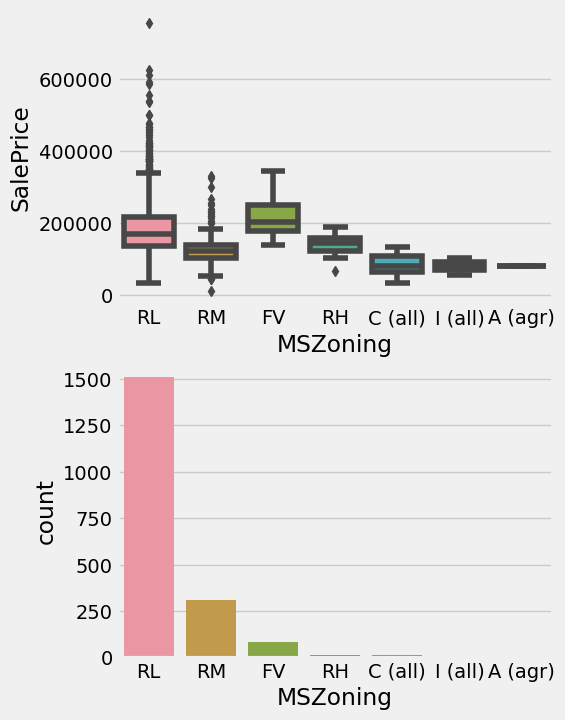

In [14]:
# do for loop sorry
plot_cat_eda('MSZoning')

I'm less sure there is much value here. 1 Fam is the most popular and it doens't behave too differently from the other categories.

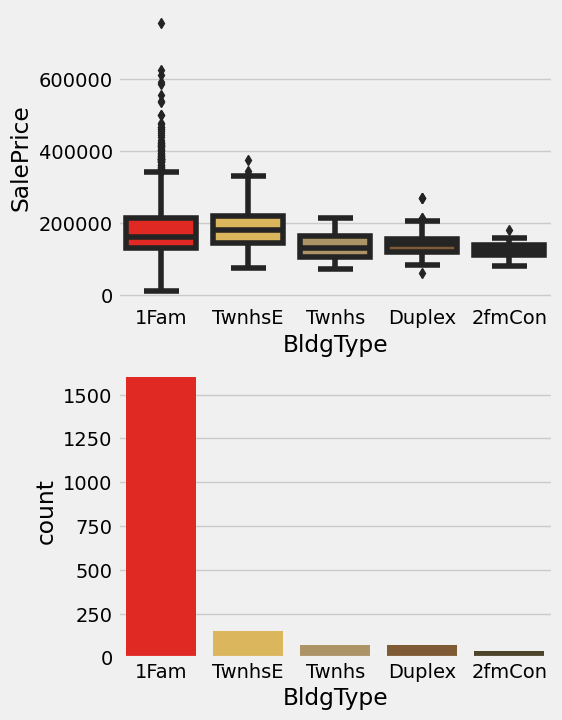

In [15]:
plot_cat_eda('BldgType')

This has more value than bldgtype. You can kinda see that more stories seem to have higher prices but 1story is also pretty solid.

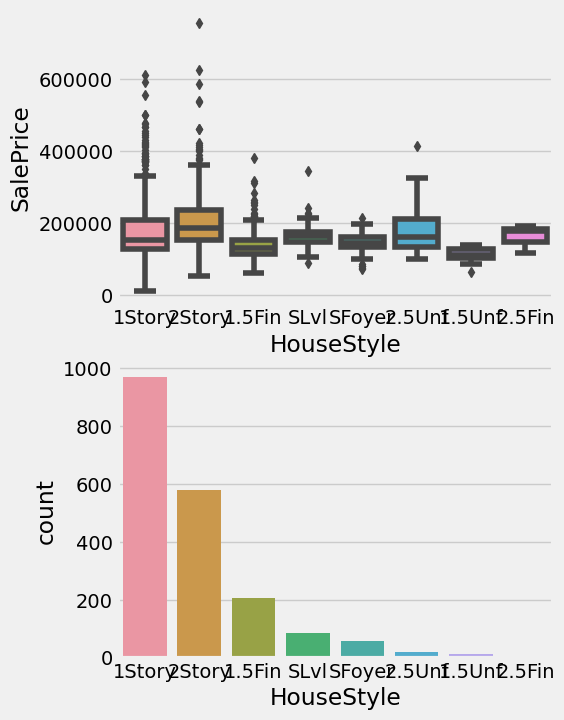

In [16]:
plot_cat_eda('HouseStyle')

this makes sense. Having 1 or 2 baths is most common. And as you have more bathrooms you expect to have a bigger and more expensive house. But I'd be interested if this is more connected to square footage or other features that predict price better than these do. Also there are 7 'FullBath' that have 0 bathrooms, which makes no sense, but they all had BsmtFullBath so that might explain it. Also makes me think that **adding all the baths together would make sense.**

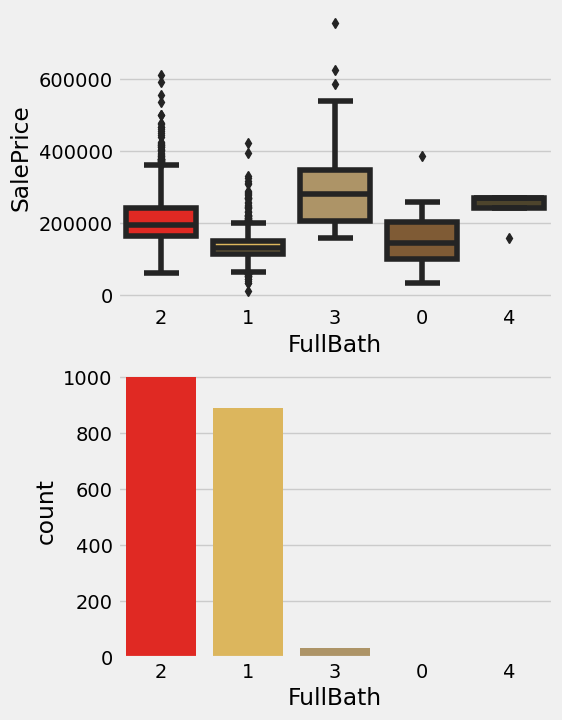

In [17]:
plot_cat_eda('FullBath')

In [18]:
train[train['FullBath']==0]['BsmtFullBath']

152     2.0
455     2.0
508     2.0
1161    2.0
1446    1.0
1464    1.0
1914    1.0
Name: BsmtFullBath, dtype: float64

Less remarkable than FullBath but again probably worth adding the bathrooms together. But is 2 half baths really worth 1 full bath. I'm not sure it is honeslty...

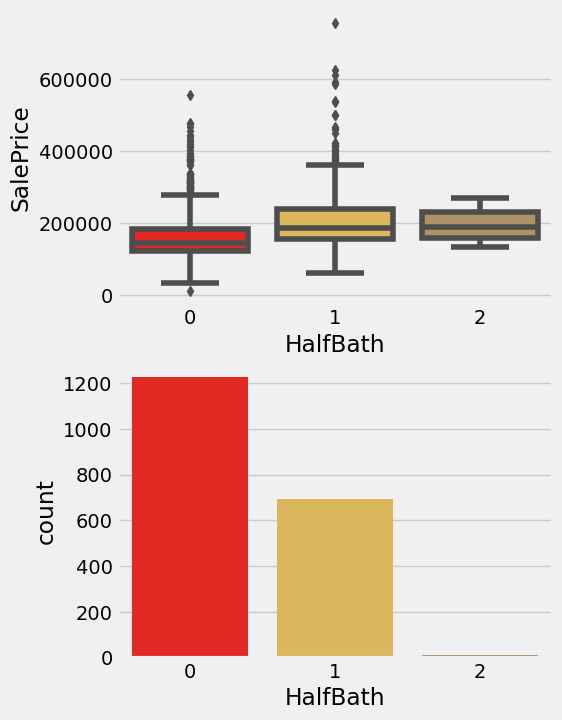

In [19]:
plot_cat_eda('HalfBath')

### Numerical features

#### PID

it is strange that one group of PIDs tends to be more expensive. but i would think looking more deeply into the lat long info that it will give us more information.

#### MiscVal

most are zero. this looks very useless.

#### YearBuilt

has some value. considering having it be years old. i would think that the machine would handle it just the same but maybe a scale of 1-100 is better than a scale of 1900-2000.

#### YearRemodAdd

this has similiar value that YearBuilt does BUT there is strnage behavior that it acts like all buildings older than 1950 had a remodel at the lastest in 1950. which like no it didnt! **this 1950 remod will need to be dealt with if it is used**

#### GrLivArea

niki has this. but it is clearly important. it makes me wonder what value 1stFlrSF and 2ndFlrSF has. maybe none? maybe there is value in having a proportion score of 1stfloor to 2nd floor SF. 

#### 1stFlrSF and 2ndFlrSF

look above.

#### LowQualFinSF

might be better to treat this as a binary. like do you have any LowQualFinSF does that hurt your score. 

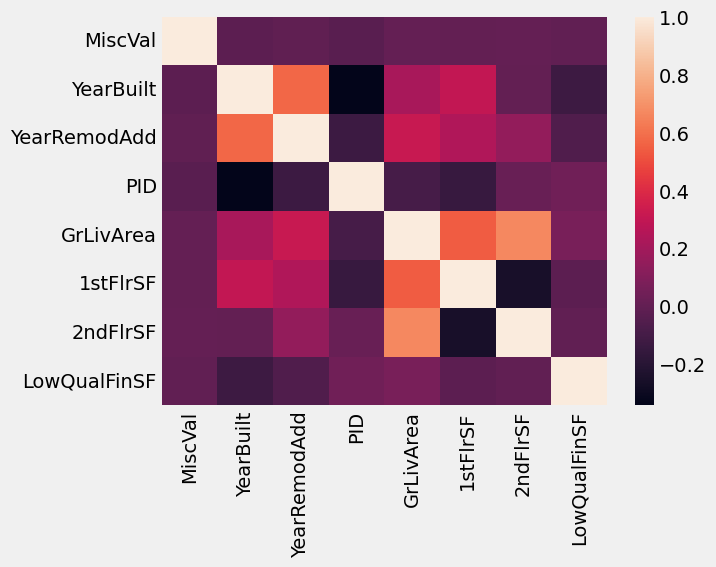

In [20]:
sns.heatmap(train[numerical_features].corr())
plt.show()

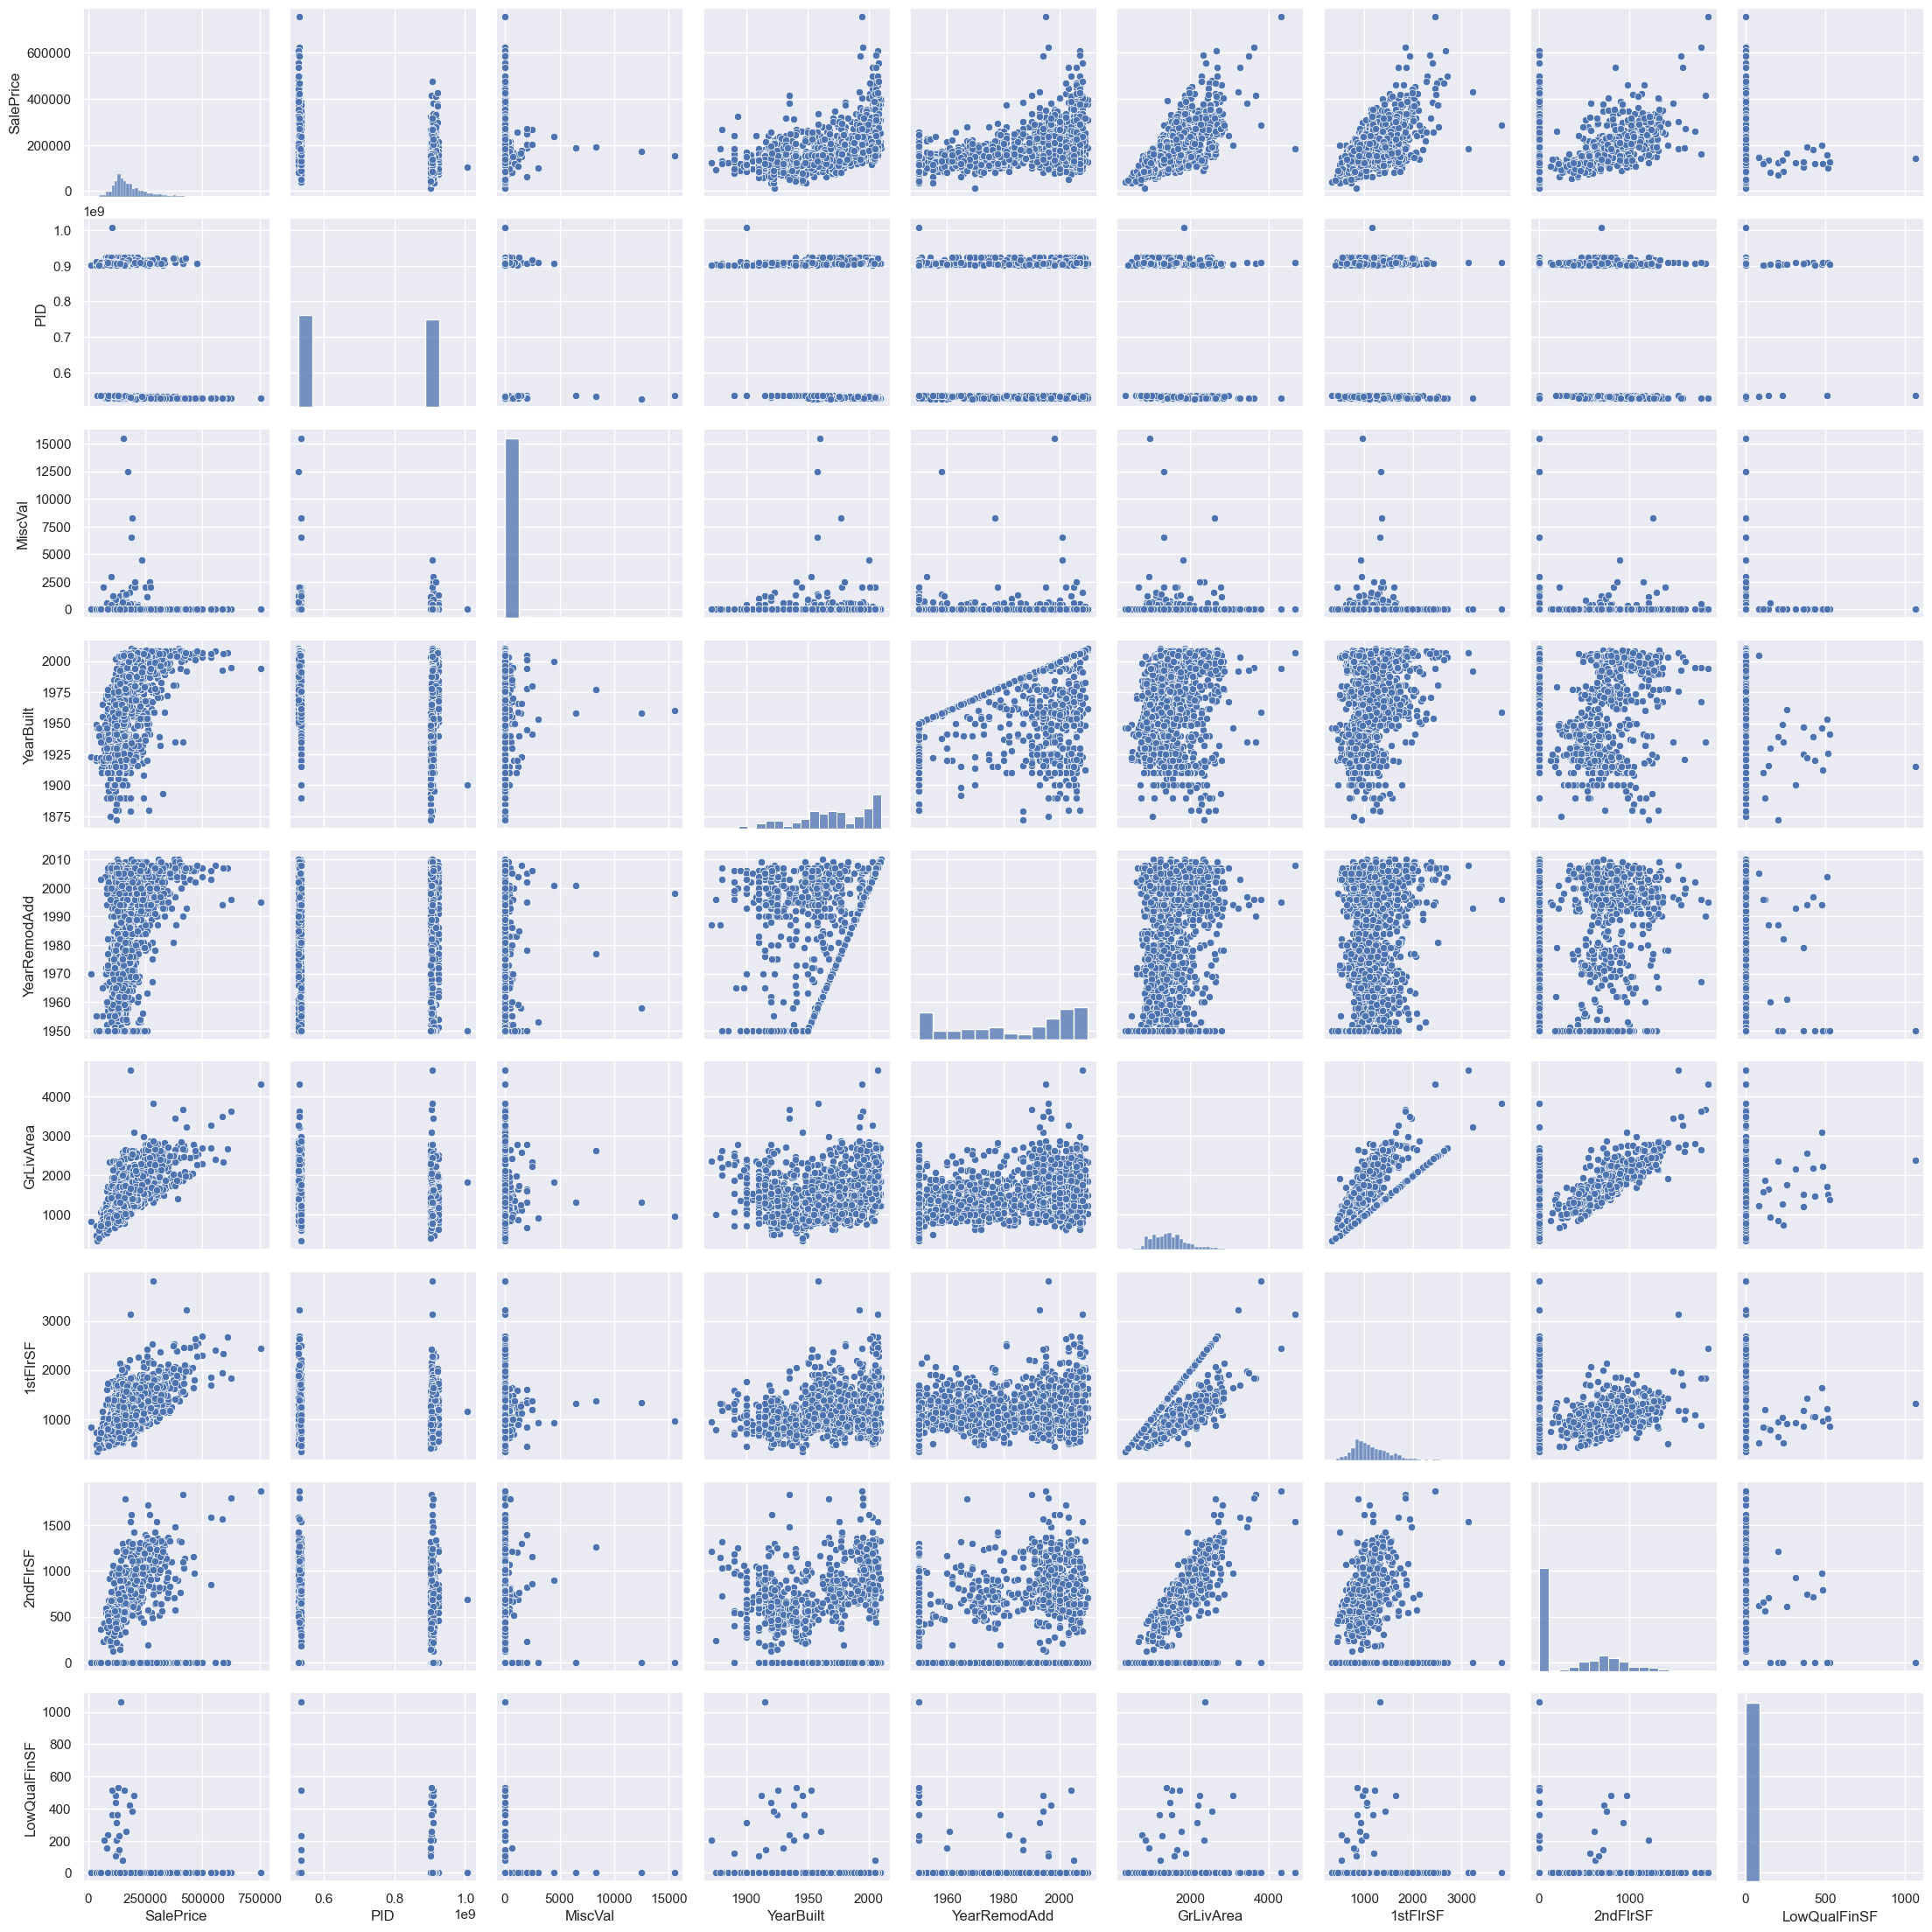

In [21]:
other_features = ['PID']
numerical_features = ['SalePrice','PID','MiscVal','YearBuilt','YearRemodAdd','GrLivArea',
                     '1stFlrSF','2ndFlrSF','LowQualFinSF']

sns.set()
sns.pairplot(train[numerical_features])
plt.show()

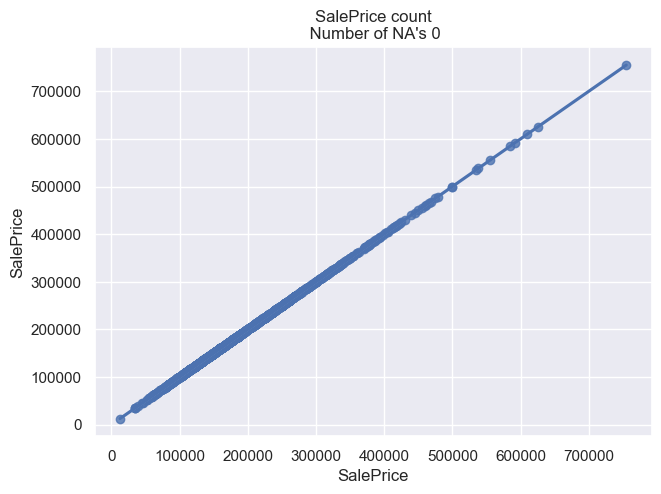

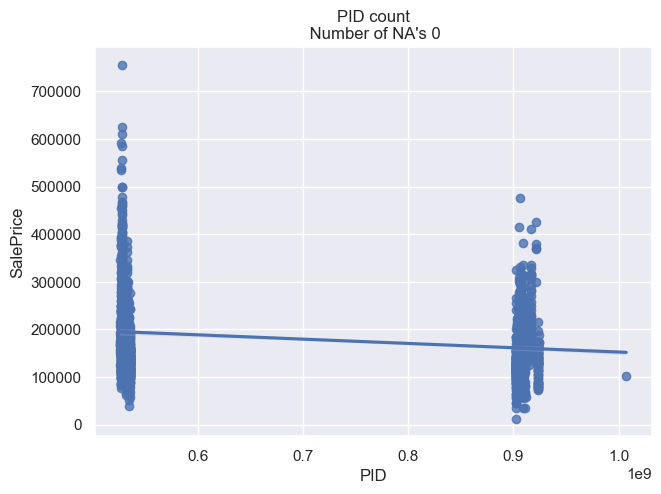

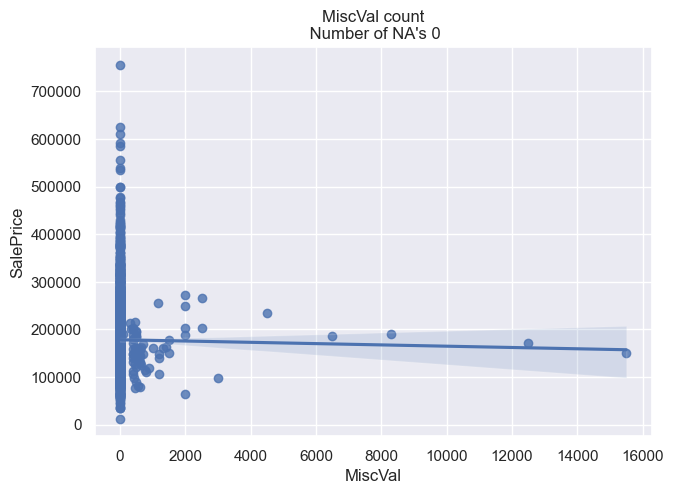

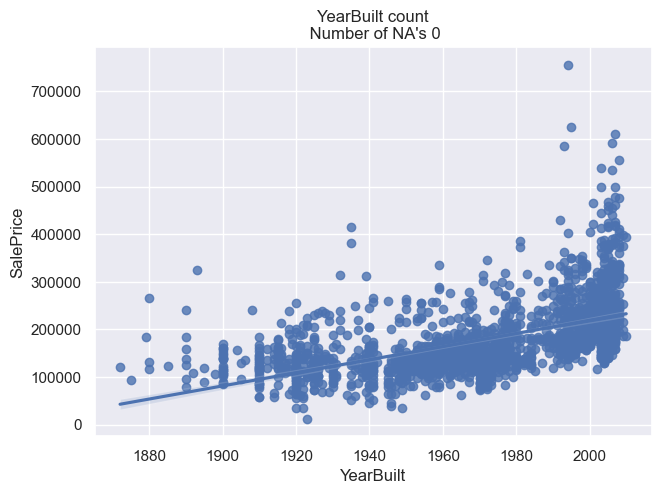

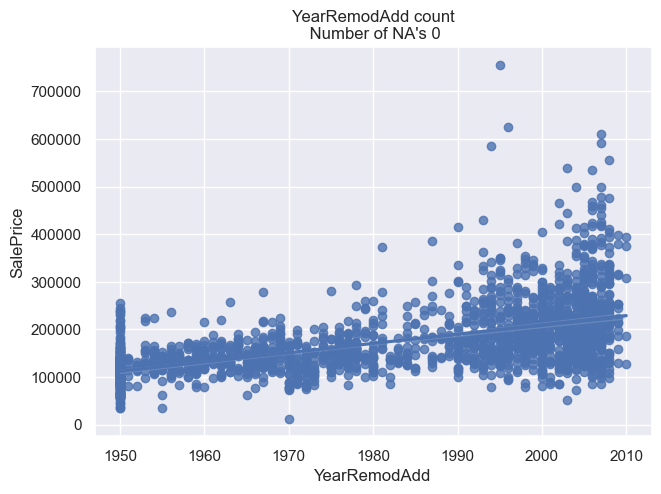

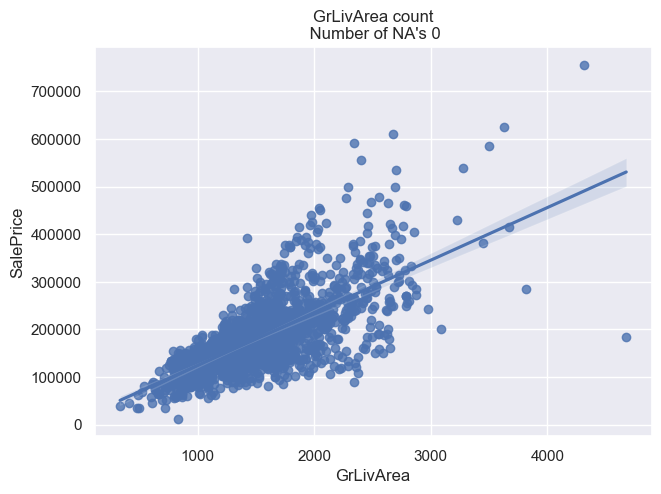

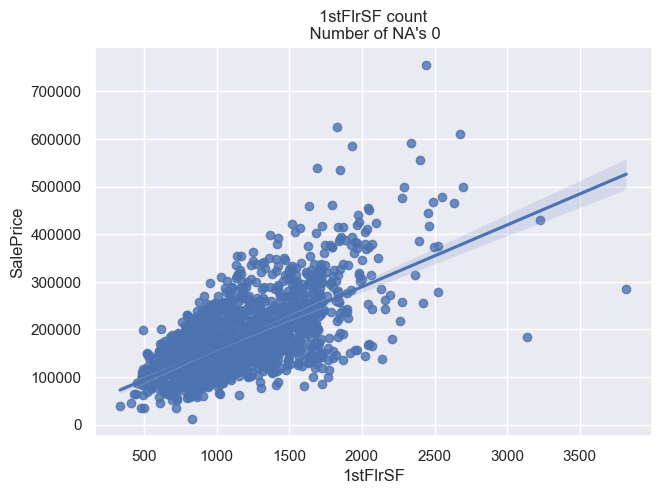

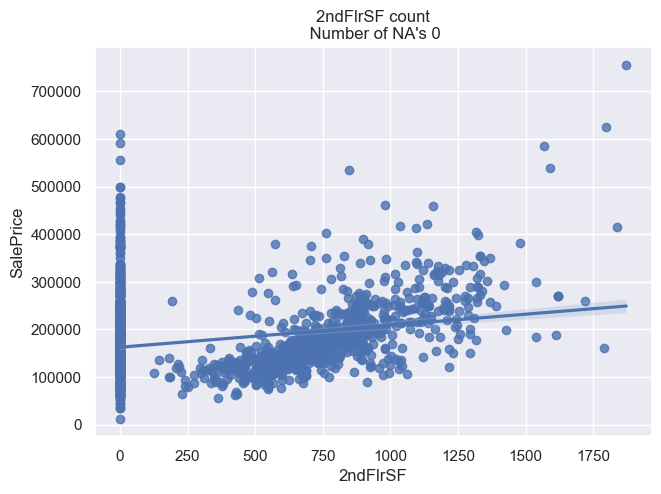

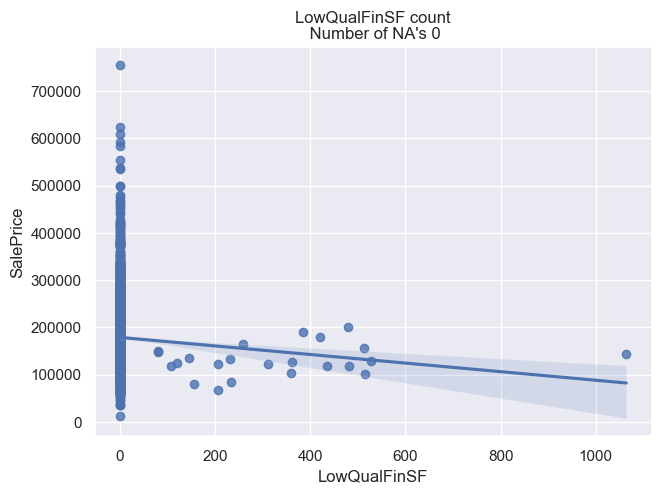

In [22]:
for numerical_feature in numerical_features:
    g = sns.regplot(x = numerical_feature, y = 'SalePrice', data = train)
    plt.title(f"{numerical_feature} count\n Number of NA's {train[numerical_feature].isnull().sum(axis = 0)}")
    plt.show()


#### Partial homes

considering removing partial homes from data set

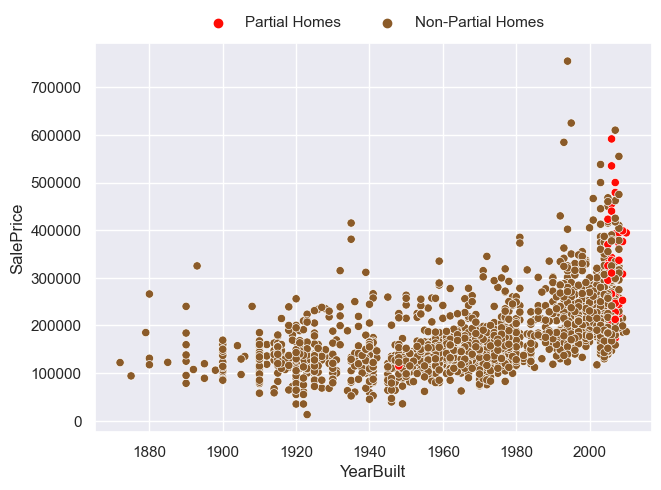

In [23]:
# colors
colors_partial = ["#FF0B04", "#8B5B29",
        ]
# prepare data for graphing
train.loc[train['SaleCondition']=='Partial','partial_'] = 'Partial Homes'
train.loc[train['SaleCondition']!='Partial','partial_'] = 'Non-Partial Homes'
#graphing
g = sns.scatterplot(x = 'YearBuilt', y = 'SalePrice', data = train,
                    hue='partial_', hue_order = ['Partial Homes','Non-Partial Homes'],
                   palette=colors_partial)
# move legend to top of graph
# newest seaborn version has a new move_legend function. New as in within this week.
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
)
plt.show()

In [24]:
# temporary work

In [ ]:
target = ['SalePrice']
key = ['PID'] 
numeric = ['GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea',
           'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
           'LowQualFinSF','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF',
           'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold'
          ]
numeric_to_categorical = ['MSSubClass','MoSold']
categorical = ['MSZoning','Street','Alley','LotShape','LandContour','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
               'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
               'BsmtFinType1','BsmtFinType2','Heating','Electrical','GarageType',
               'GarageFinish','PavedDrive','MiscFeature','SaleType','SaleCondition'
              ]
binary = ['CentralAir',
         
         ]
cat_ordinal = ['Utilities',
               'OverallQual','OverallCond',
               'ExterQual','ExterCond',
               'BsmtQual','BsmtCond',
               'BsmtExposure',
               'HeatingQC',
               'BsmtFullBath','BsmtHalfBath',
               'FullBath','HalfBath',
               'BedroomAbvGr',
               'KitchenAbvGr',
               'KitchenQual',
               'TotRmsAbvGrd',
               'Functional',
               'Fireplaces',
               'FireplaceQu',
               'GarageCars',
               'GarageQual',
               'GarageCond',
               'PoolQC',
               'Fence'
               
               
              ]

In [25]:
train.columns

Index(['PID', 'GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond

In [40]:
train.iloc[:,60:0].head()

,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType
0,0,130,0,NaN,NaN,None,0,6,2008,WD
1,0,0,0,NaN,NaN,None,0,6,2009,WD
2,0,180,0,NaN,NaN,None,0,4,2009,WD
3,0,0,0,NaN,NaN,None,0,6,2008,WD
4,0,0,0,NaN,GdPrv,None,0,11,2009,WD


In [45]:
train['SaleType'].unique()

array(['WD ', 'COD', 'ConLD', 'New', 'Con', 'ConLw', 'CWD', 'Oth',
       'ConLI', 'VWD'], dtype=object)